# Neuroscience 🧠 using fastplotlib 🦜

This notebook will build up a complex visualization using `fastplotlib`, in conjunction with `pynapple`, to show how `fastplotlib` can be a powerful tool in analysis and visualization of neural data!

In [3]:
import fastplotlib as fpl
import pynapple as nap
import numpy as np
from ipywidgets import IntSlider, Layout, VBox, HBox, FloatSlider
from sidecar import Sidecar
from skimage import measure
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import gaussian_filter1d
from store_model import TimeStore

In [4]:
import warnings
warnings.simplefilter('ignore')

In [5]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Load the data

#### Recording of a freely-moving mouse imaged with a Miniscope (1-photon imaging). The area recorded is the postsubiculum - a region that is known to contain head-direction cells, or cells that fire when the animal's head is pointing in a specific direction.

In [6]:
data = nap.load_file("./data.nwb")

In [7]:
data

data
┍━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━┑
│ Keys                  │ Type        │
┝━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━┥
│ position_time_support │ IntervalSet │
│ RoiResponseSeries     │ TsdFrame    │
│ calcium_video         │ TsdTensor   │
│ beh_video             │ TsdTensor   │
│ z                     │ Tsd         │
│ y                     │ Tsd         │
│ x                     │ Tsd         │
│ rz                    │ Tsd         │
│ ry                    │ Tsd         │
│ rx                    │ Tsd         │
┕━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━┙

### Let's view the behavior and calcium data

**NOTE:** We are going to be using a WIP `TimeStore` model to help synchronize our visualization in time. 

In [8]:
time_store = TimeStore()

Behavior data and shape 🐭

In [9]:
behavior_data = data["beh_video"]
behavior_data.shape  # (time, x, y)

(9045, 204, 256)

Calcium data and the shape 🔬

In [10]:
calcium_data = data["calcium_video"]
calcium_data.shape  # (time, x, y)

(17886, 136, 166)

#### Set our view of the data to where both behavior and position data are available:

In [11]:
behavior_data = behavior_data.restrict(data["position_time_support"])
calcium_data = calcium_data.restrict(data["position_time_support"])

(data["position_time_support"].start[0], data["position_time_support"].end[0])

(np.float64(7.39305), np.float64(1213.22765))

RFBOutputContext()

Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.


JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
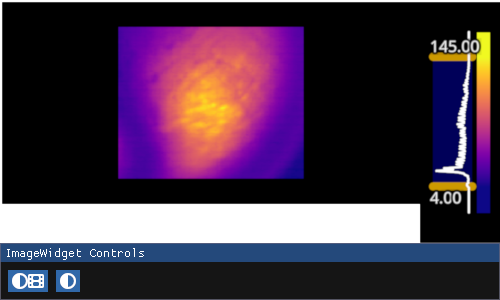

In [12]:
# calculate min frame across movie
# remove vignette effect from 1p endoscopic imaging
min_frame = calcium_data.min(axis=0)

# just to show you what this looks like
iw = fpl.ImageWidget(min_frame)
iw.show()

In [13]:
iw.close()

## Create a big viz for calcium and behavior video! 🎨

In [14]:
# make figure, calcium on left, behavior on right
nap_figure = fpl.Figure(shape=(1,2), names=[["calcium", "behavior"]])

# image graphic to display current calcium frame
calcium_graphic = nap_figure["calcium"].add_image(data=calcium_data[0] - min_frame, name="calcium_frame", cmap="gnuplot2")

# a UI tool to help set and visualize vmin-vmax
hlut = fpl.HistogramLUTTool(data=calcium_data, image_graphic=calcium_graphic)
# add this to the right dock
nap_figure["calcium"].docks["right"].add_graphic(hlut)
nap_figure["calcium"].docks["right"].size = 80
nap_figure["calcium"].docks["right"].auto_scale(maintain_aspect=False)
nap_figure["calcium"].docks["right"].controller.enabled = False

# image graphic to display current behavior video frame
behavior_graphic = nap_figure["behavior"].add_image(data=behavior_data[0], cmap="gray")

RFBOutputContext()

#### Create a slider that updates the behavior and calcium videos using `pynapple`

In [15]:
# This time will be in seconds
synced_time = FloatSlider(min=data["position_time_support"].start, max=data["position_time_support"].end, step=0.01, description="s")

# auto-resize slider
@nap_figure.renderer.add_event_handler("resize")
def resize_slider(ev):
    synced_time.layout = Layout(width=f"{ev.width}px")

#### Add the components of our visualization to the `TimeStore` model to be synchronized 🕰️

In [16]:
# add the slider
time_store.subscribe(subscriber=synced_time)

def substract_min(frame):
    """subtract min frame from current frame"""
    global min_frame

    return frame - min_frame

# add our calcium data
time_store.subscribe(subscriber=calcium_graphic, data=calcium_data, data_filter=substract_min)

# add our behavior data
time_store.subscribe(subscriber=behavior_graphic, data=behavior_data)

**Here we are going to use `sidecar` to organize our visualizations better :D**

In [17]:
sc = Sidecar()
with sc:
    display(VBox([nap_figure.show(), synced_time]))

# Visualize Calcium Imaging ROIs

#### Calculate the spatial contours and overlay them on the raw calcium data

In [18]:
# get the masks
contour_masks = data.nwb.processing['ophys']['ImageSegmentation']['PlaneSegmentation']['image_mask'].data[:]
# reshape the masks into a list of 105 components
contour_masks = list(contour_masks.reshape((len(contour_masks), 166, 136)))

In [19]:
# calculate each contour from the mask using `scikit-image.measure`
contours = list()

for mask in contour_masks:
    contours.append(np.vstack(measure.find_contours(mask)))

#### Add the calculated contours as an overlay to the calcium video

In [20]:
contours_graphic = nap_figure["calcium"].add_line_collection(data=contours, colors="w", alpha=0.8)

**It is very easy to see that many of the identified neurons may be "bad" candidates. Let's remove them from the dataset as we go on in our anaylsis.**

### Select only head-direction neurons

In [21]:
# get the temporal data (calcium transients) from the nwb notebook
temporal_data = data["RoiResponseSeries"][:].restrict(data["position_time_support"])
temporal_data

Time (s)     0        1        2        3        4        ...
-----------  -------  -------  -------  -------  -------  -----
7.4          4.25336  0.1776   1.36078  0.4559   0.22819  ...
7.433333     4.23919  0.17688  1.35602  0.45423  0.22733  ...
7.466667     4.22506  0.17617  1.35128  0.45257  0.22647  ...
7.5          4.21097  0.17546  1.34655  0.5235   0.22562  ...
7.533333     4.19693  0.17475  1.34184  0.57631  0.22476  ...
7.566667     4.18294  0.17404  1.33714  0.74999  0.22392  ...
7.6          4.16899  0.17334  1.33246  0.88075  0.22307  ...
...          ...      ...      ...      ...      ...      ...
1192.166667  2.54202  0.14531  0.44013  0.5681   0.65477  ...
1192.2       2.53029  0.14775  0.43842  0.56657  0.65227  ...
1192.233333  2.51861  0.14962  0.43671  0.56505  0.64979  ...
1192.266667  2.50698  0.15104  0.435    0.56354  0.64731  ...
1192.3       2.49541  0.15209  0.43331  0.56202  0.64485  ...
1192.333333  2.48389  0.15283  0.43162  0.58476  0.64239  ...
1192.3

In [22]:
# compute 1D tuning curved based on head angle
head_angle = data["ry"]

tuning_curves = nap.compute_1d_tuning_curves_continuous(temporal_data, head_angle, nb_bins = 120)

#### Select the top 50 components

In [23]:
# select good components 
good_ixs = list(np.argsort(np.ptp(tuning_curves, axis=0))[-50:])
bad_ixs = list(np.argsort(np.ptp(tuning_curves, axis=0))[:-50])

#### Color the "good" and "bad" components

In [24]:
contours_graphic[good_ixs].colors = "w"
contours_graphic[bad_ixs].colors = "magenta"

#### Sort the "good" components based on preferred head direction

In [25]:
# sorting the "good" neurons based on preferred directions
sorted_ixs = tuning_curves.iloc[:,good_ixs].idxmax().sort_values().index.values

In [26]:
sorted_ixs

array([34, 75, 77, 86, 21, 16,  6,  4, 44, 58, 14, 33, 94, 98, 76, 90,  7,
        5, 82, 28, 15, 45, 88, 39, 24, 18, 20, 60, 13,  0,  8, 27, 10, 78,
        2, 85, 19,  3, 17, 38, 30, 29, 25, 84, 12, 26, 41,  9, 11,  1])

#### Filter the dataset to only use the sorted "good" components

In the rest of the demo we will only be using the sub-sampled components.

In [27]:
# filter dataset based on sortex indices
temporal_data = temporal_data[:,sorted_ixs]
contours = [contours[i] for i in sorted_ixs]

#### Plot only the "good" components

In [28]:
# remove the graphic of all the components
nap_figure["calcium"].remove_graphic(contours_graphic)

# re-plot only the good ixs
contours_graphic = nap_figure[0, 0].add_line_collection(data=contours, colors="w", alpha=0.8)

## Visualize all calcium tracing using an `ImageGraphic` to display a Heatmap

In [29]:
# create a figure, 2 rows, 1 column
temporal_fig = fpl.Figure(shape=(2,1), names=[["temporal-heatmap"], ["tuning-curve"]])

RFBOutputContext()

In [30]:
# we need to transpose our temporal data so that it is (# components, time (s))
raw_temporal = temporal_data.to_numpy().T

# use 'hsv' colormap to represent preferred head direction 
heatmap_graphic = temporal_fig[0,0].add_image(data=raw_temporal, cmap="plasma", name="traces")

#### Add a `LinearSelector` that we can map to our behavior and calcium videos

In [31]:
time_selector = heatmap_graphic.add_linear_selector()

In [32]:
component_selector = heatmap_graphic.add_linear_selector(axis="y")

In [33]:
# subscribe selector to timestore
time_store.subscribe(subscriber=time_selector, multiplier=temporal_data.rate)

#### Let's view everything together

In [34]:
@nap_figure.renderer.add_event_handler("resize")
def resize_temporal_fig(ev):
    temporal_fig.canvas.set_logical_size(ev.width, 300)

sc = Sidecar()

with sc:
    display(VBox([nap_figure.show(), temporal_fig.show(maintain_aspect=False), synced_time]))

In [35]:
# select the first component
ix = 0

# set the first component colors to magenta
contours_graphic[ix].colors = "green"

# get the tuning curve of the first component 
tuning_ix = sorted_ixs[ix]

tuning_curve = tuning_curves.T.iloc[tuning_ix]

# add the tuning curve to the plot as a line
tuning_graphic = temporal_fig["tuning-curve"].add_line(data=tuning_curve, offset=(0,0,0))
temporal_fig["tuning-curve"].auto_scale(maintain_aspect=False)

### Add an event handler that allows us to "scroll" through the traces and tuning curves :D

In [36]:
# add an event handler that allows tabbing up and down traces
@component_selector.add_event_handler("selection")
def update_selected_trace(ev):
    ix = ev.get_selected_index()
    
    # reset the colors of the components to white
    contours_graphic.colors = "w"

    # set the selected component colors to magenta
    contours_graphic[ix].colors = "green"

    nap_figure["calcium"].camera.show_object(contours_graphic[ix].world_object)

    # get tuning curve of the selected component
    tuning_ix = sorted_ixs[ix]

    tuning_curve = tuning_curves.T.iloc[tuning_ix]

    # remove the current tuning curve add the new one
    #global tuning_graphic
    temporal_fig["tuning-curve"].graphics[0].data[:,1] = tuning_curve
    temporal_fig["tuning-curve"].auto_scale(maintain_aspect=False)
    

    #tuning_graphic = tstack_fig[1,0].add_line(data=tuning_curve, offset=(0,0,0))

# Downstream analysis, view a PCA of the calcium

In [37]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

#### Perform PCA

In [38]:
pca = PCA(n_components=3)

rs = RobustScaler()
scaled = rs.fit_transform(gaussian_filter1d(temporal_data.to_numpy(), sigma=5))
calcium_pca = pca.fit_transform(scaled)

#### Plot the PCA results

To get a proper colormap transform based on the head angle data, need to interpolate the time scale.

In [39]:
# restrict the head angle data 
ry_restrict = data["ry"].restrict(data["position_time_support"])

In [40]:
x = np.arange(0, temporal_data.shape[0])
xp = np.linspace(0, temporal_data.shape[0], ry_restrict.shape[0])

# interpolate 
ry_transform =  np.interp(x, xp, fp=ry_restrict)  # use the y-values

RFBOutputContext()

JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
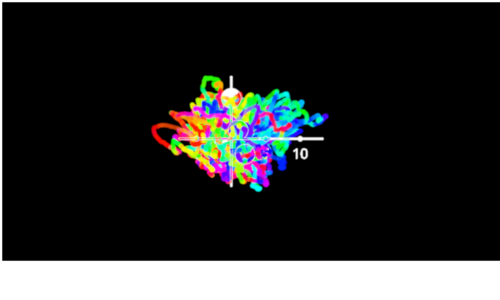

In [41]:
fig_pca = fpl.Figure(
    cameras="3d",
    controller_types="orbit",
)
fig_pca[0, 0].add_scatter(calcium_pca, cmap="hsv", cmap_transform=ry_transform, sizes=4, alpha=0.4)
marker_graphic = fig_pca[0, 0].add_scatter(calcium_pca[0], sizes=20)

fig_pca.show()

#### Subscribe the PCA marker to the `TimeStore` model

In [42]:
# create a `pynapple.TsdFrame` for the PCA data
pca_data = nap.TsdFrame(t=temporal_data.t, d=calcium_pca)

time_store.subscribe(subscriber=marker_graphic, data=pca_data, multiplier=temporal_data.rate)

Can change the controller

In [43]:
fig_pca[0, 0].controller = "fly"